# Lab Assignment Seven: RNNs

## Team Members
1. Piyush Metkar  - 47509180
2. Rishab Vaishya - 47505527
3. Dhaval Gogri   - 47444609

# BUSINESS UNDERSTANDING

REFERENCE : https://www.kaggle.com/uciml/sms-spam-collection-dataset

This dataset is taken from Kaggle and it is about SMSs(Text messages or Short message service) which are classified as spam and not-spam(ham). We have total of around 5500 rows of data which will be trained. 

Nowadays, almost every individual carries a mobile device, we get a lot of messages which are not relevant to us via SMSs, emails, etc. They take up a lot of space and also waste our time going through them on a daily basis. We need to filter all those SMSs, emails which are not important to us. 

As this is becoming more and more frequent in our mundane life, we can see that many companies are adopting the practice of filtering spam messages.Companies like Google, Microsoft uses these kind of filterings to avoid spam emails, mobile apps like Truecaller identitfies and filters spam SMSs and spam Calls. Even cellphone carriers provides 'Do Not Disturb' options for their customers. 

Our model will help in identifying and classifying messages that we receive on a daily basis as Ham or Spam, this will save disk space and user’s time to read and go through unwanted messages. It will also save people from fraudsters who have previously been identified as . 

But another important thing that is to be noted is those sms, emails which are actually ham should not be classified as spam. It could result in user missing a very important sms, email.

For this case we are looking the model to perform at really good rate and expect accuracy more than 95%.

Ref : https://github.com/eclarson/MachineLearningNotebooks/blob/master/13.%20RNN%20Basics.ipynb
Some of the code has been used from the above source with modifications.


# 1. GRADING RUBRIC

## 1.1 Data Preparation

The 2 columns in CSV file are named as 'v1' and 'v2'. We rename these columns as 'Type' and 'Message' to have a avoid any confusion.


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from sklearn import metrics as mt
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from keras.models import Model
from keras.layers import LSTM, SimpleRNN, GRU, Activation, Input, Embedding, Dense, Dropout
from keras.callbacks import EarlyStopping


%matplotlib inline
plt.style.use('ggplot')

df = pd.read_csv('/Users/piyushmetkar/Documents/SMU/Notes/Spring 18/7324 Machine Learning in Python/Lab 7/spam.csv', encoding='latin-1')
# df = pd.read_csv(r'D:\Downloads\Notes\CSE_7324_ML\sms-spam-collection-dataset\spam.csv', encoding='latin-1') 
#df = pd.read_csv('/Users/dhavalgogri/Downloads/sms-spam-collection-dataset/spam.csv', encoding='latin-1') 

df.head()


Using TensorFlow backend.


,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
Type       5572 non-null object
Message    5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


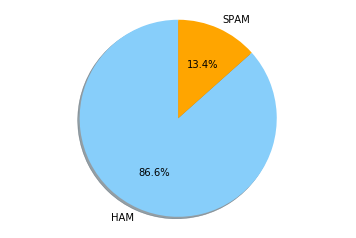

In [2]:
import numpy as np
df.rename( columns={'v1': 'Type', 'v2': 'Message'}, inplace=True)
df.info()
colors = [ 'lightskyblue', 'orange']

# Plot
plt.pie(df.groupby('Type').count().Message, labels=np.asarray(['HAM', 'SPAM']), colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.show()

In [3]:
df['Type'].replace(['ham', 'spam'], [0, 1],inplace=True)

X = df.Message
y = df.Type

from sklearn.model_selection import  StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

Keras does not work with string data type. It accepts integer with default type as int32. In order to convert the textual data in matrices, we use tokenizer.

In our dataset we have around 5500 text messages, 80000 combined words(not unique). On an average there are 16 words per message. Although many messages have 100s of words in them.

We will be using only top 5000 words out of all the words present in the dataset. We will all also truncate and pad input sequences to same length. The maximum number of words we want in our input sequence is 50. This is because most of the spam messages won't as long as some personal messages and here we are focusing on spam messages. We also do embedding for input sequences and reduce their dimensionality to 10 words.

In [29]:
max_words = 5000
max_len = 50
embeddings = [10,15,20]
denseLayerSizes = [200,256,300]

tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

sequences_test = tok.texts_to_sequences(X_test)
sequences_matrix_test = sequence.pad_sequences(sequences_test,maxlen=max_len)

## 1.2 Evaluation Metric

As per our business case, it is very important for us that our model predicts spam as a spam and ham as a ham but more importantly, it **SHOULD NOT** predict a HAM as a SPAM. This could result in a very important message to be classified as a spam and deleted/neglected by our model. 

So based on the above criteria we also need to reduce the number of false positives, so we will need to have 2 evaluation metrics
1. Accuracy
2. Precision

## 1.3 Cross Validation

For cross validation we will be using **Stratified Shuffle Split**. This is because we have very uneven distribution of data for both the classes. Stratified split ensures that the distribution of data is even in train and test splits.

We will split the data in the ratio of 80:20 for train-test. The model will be trained on 80% data. This data will again be split in every epoch in ratio 80:20 for train-validation.


In [5]:
# Reference : https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2
# We need precision score for our epochs, so added precision code and removed the f1 code.

class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_precision = precision_score(val_targ, val_predict, average='micro')
        self.val_precisions.append(_val_precision)
        print ('PRECISION VALUE:', _val_precision)# — val_acc: %f — val_precision: %f — val_recall %f” %(_val_f1, _val_precision, _val_recall)
        return
 
metrics = Metrics()

In [43]:
# ref: https://www.kaggle.com/danbrice/keras-plot-history-full-report-and-grid-search
# Code has been used as it is from the above source
# following code helps to visualize the history of the models.

import matplotlib.pyplot as plt
import itertools

def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    
    ## Loss
    plt.rcParams["figure.figsize"] = (20,6)
    plt.subplot(1, 2, 1)
#     plt.figure(figsize=(10,6))
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    ## Accuracy
#     plt.figure(figsize=(10,6))
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

## 1.3 Modeling

We will be using SimpleRNN, LSTM and GRU. We will vary the embedding sizes for each of the recurrent architectures and change parameters such as number of hidden layers for each architecture. We are trying 3 embedding size values. Thus we generate 9 architectures. For each architecture we tune the number of dense hidden layers. In total we are generating 27 different models and comparing their accuracy & precision values to figure which model suits best for our case.

Ref: https://www.kaggle.com/kredy10/simple-lstm-for-text-classification/code

The model layers have been referenced from above source. We are tuning parameters and changing size of embeddings in the above code for our comparison of different models.

In [10]:
# ref : http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
class_names = ['Spam', 'Ham']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')






==================================== SimpleRNN Summary ======================================== 
Dense layer size :  200
Embedding layer size :  10 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 50)                0         
_________________________________________________________________
embedding_30 (Embedding)     (None, 50, 10)            50000     
_________________________________________________________________
simple_rnn_30 (SimpleRNN)    (None, 64)                4800      
_________________________________________________________________
FC1 (Dense)                  (None, 200)               13000     
_________________________________________________________________
activation_59 (Activation)   (None, 200)               0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 200)            

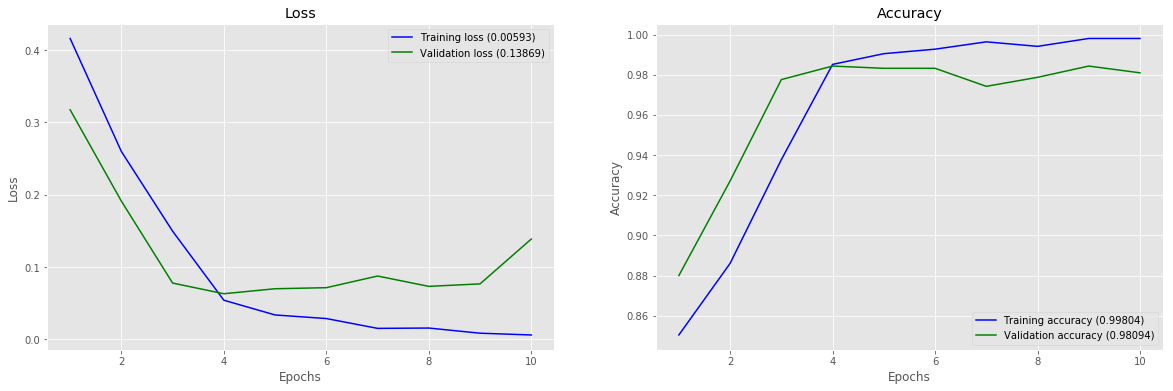

Confusion matrix, without normalization
[[966   0]
 [ 22 127]]





==================================== SimpleRNN Summary ======================================== 
Dense layer size :  256
Embedding layer size :  10 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 50)                0         
_________________________________________________________________
embedding_31 (Embedding)     (None, 50, 10)            50000     
_________________________________________________________________
simple_rnn_31 (SimpleRNN)    (None, 64)                4800      
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_61 (Activation)   (None, 256)               0         
_______________________________________________________

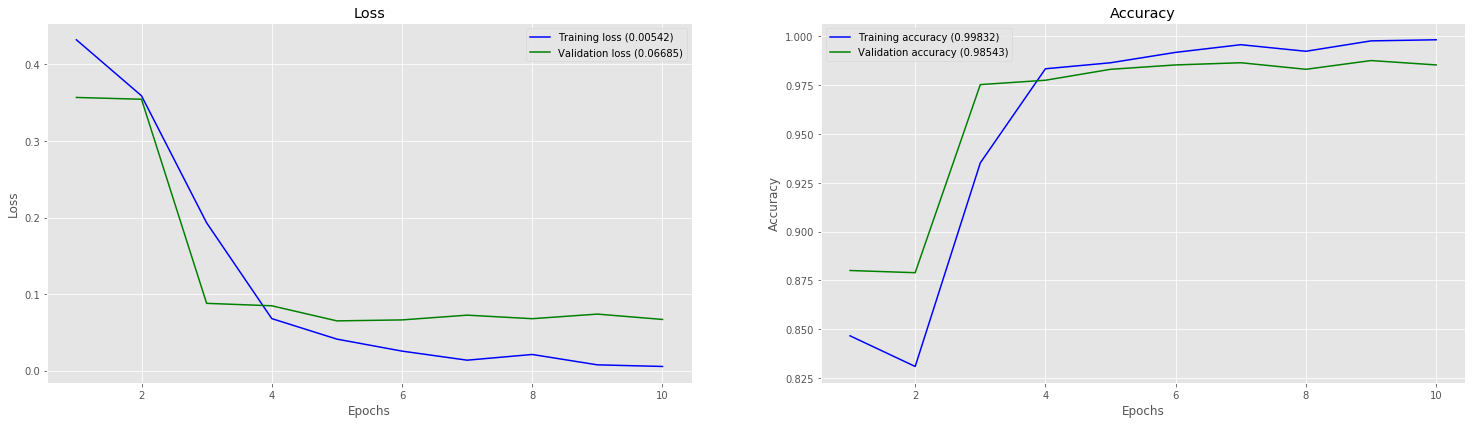

Confusion matrix, without normalization
[[966   0]
 [ 11 138]]





==================================== SimpleRNN Summary ======================================== 
Dense layer size :  300
Embedding layer size :  10 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 50)                0         
_________________________________________________________________
embedding_32 (Embedding)     (None, 50, 10)            50000     
_________________________________________________________________
simple_rnn_32 (SimpleRNN)    (None, 64)                4800      
_________________________________________________________________
FC1 (Dense)                  (None, 300)               19500     
_________________________________________________________________
activation_63 (Activation)   (None, 300)               0         
_______________________________________________________

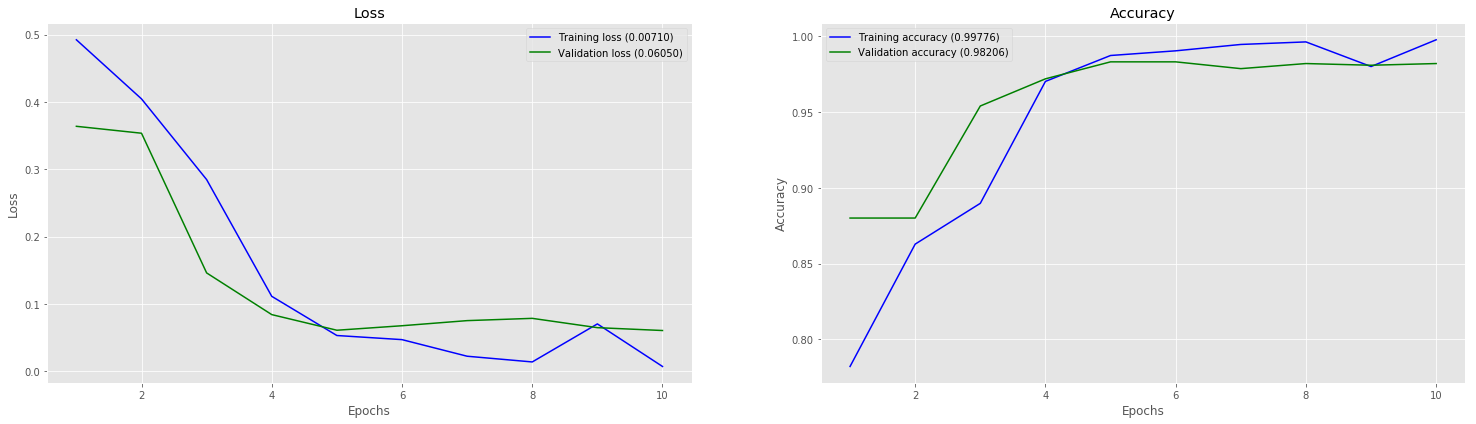

Confusion matrix, without normalization
[[965   1]
 [  6 143]]





==================================== SimpleRNN Summary ======================================== 
Dense layer size :  200
Embedding layer size :  15 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 50)                0         
_________________________________________________________________
embedding_33 (Embedding)     (None, 50, 15)            75000     
_________________________________________________________________
simple_rnn_33 (SimpleRNN)    (None, 64)                5120      
_________________________________________________________________
FC1 (Dense)                  (None, 200)               13000     
_________________________________________________________________
activation_65 (Activation)   (None, 200)               0         
_______________________________________________________

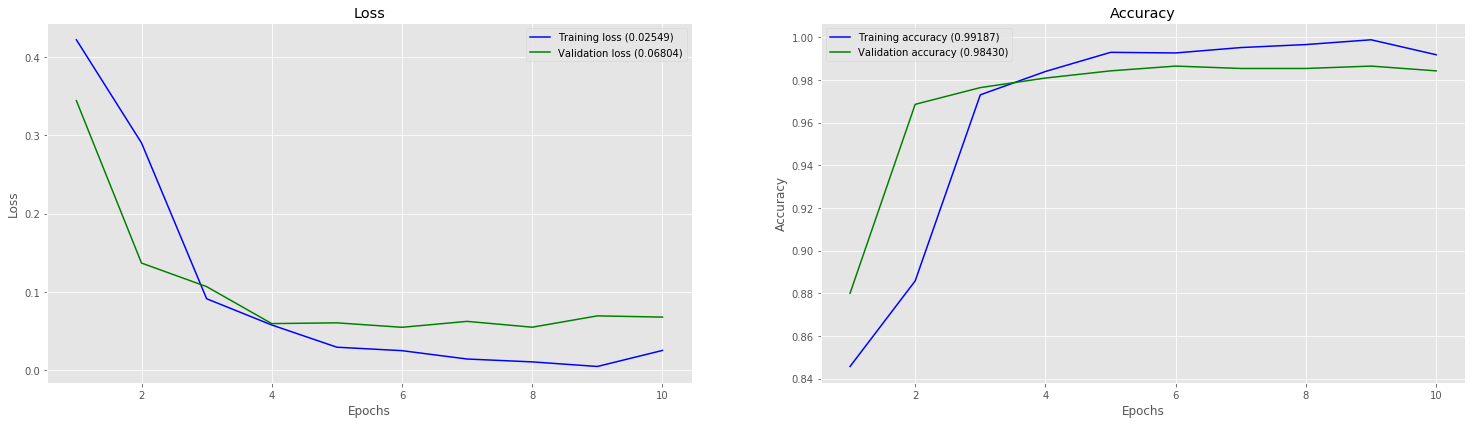

Confusion matrix, without normalization
[[966   0]
 [ 10 139]]





==================================== SimpleRNN Summary ======================================== 
Dense layer size :  256
Embedding layer size :  15 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 50)                0         
_________________________________________________________________
embedding_34 (Embedding)     (None, 50, 15)            75000     
_________________________________________________________________
simple_rnn_34 (SimpleRNN)    (None, 64)                5120      
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_67 (Activation)   (None, 256)               0         
_______________________________________________________

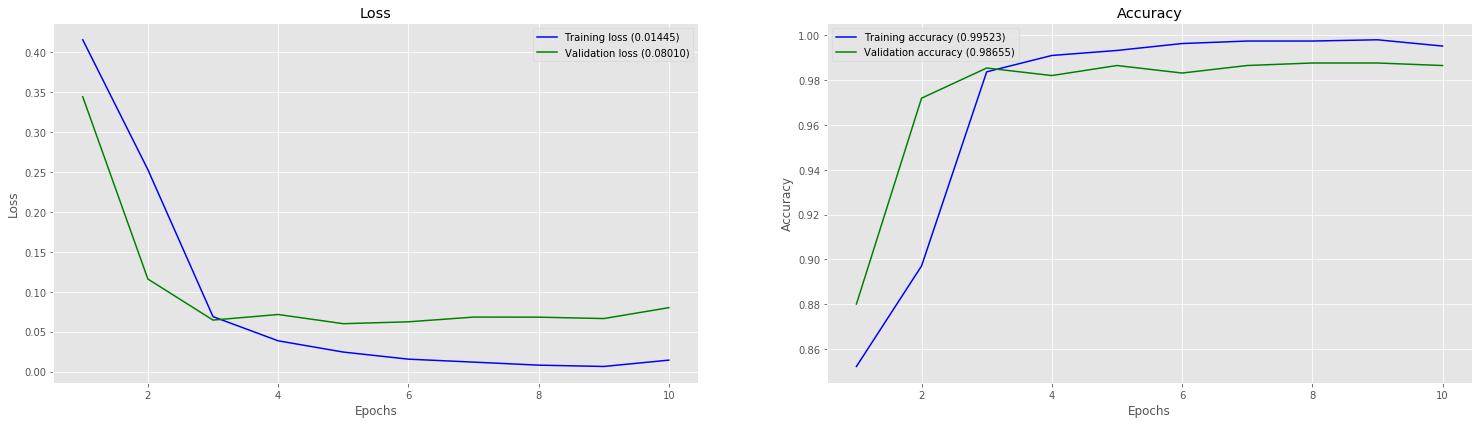

Confusion matrix, without normalization
[[965   1]
 [  9 140]]





==================================== SimpleRNN Summary ======================================== 
Dense layer size :  300
Embedding layer size :  15 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 50)                0         
_________________________________________________________________
embedding_35 (Embedding)     (None, 50, 15)            75000     
_________________________________________________________________
simple_rnn_35 (SimpleRNN)    (None, 64)                5120      
_________________________________________________________________
FC1 (Dense)                  (None, 300)               19500     
_________________________________________________________________
activation_69 (Activation)   (None, 300)               0         
_______________________________________________________

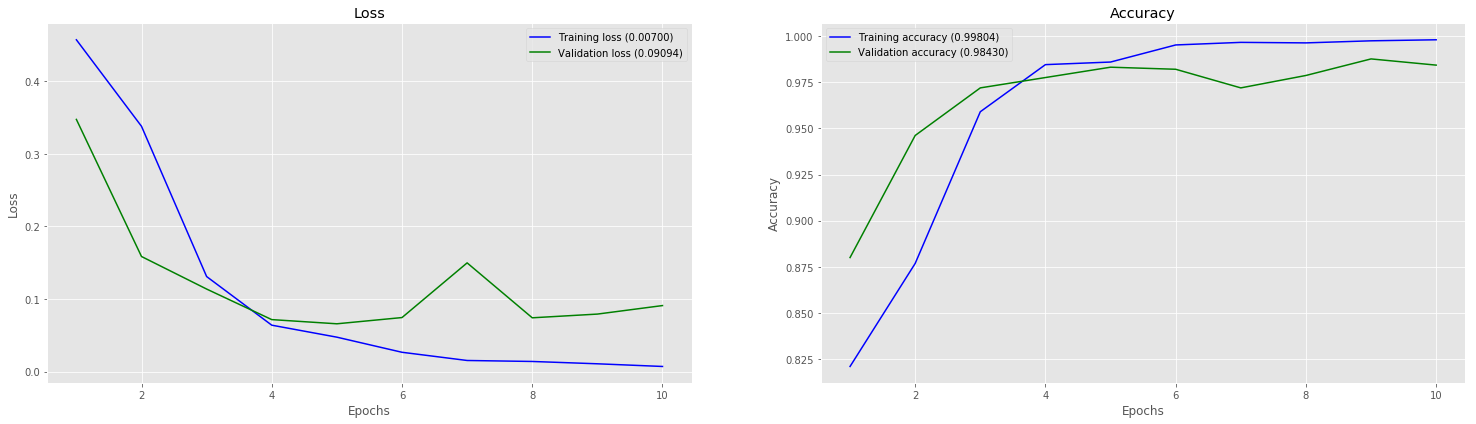

Confusion matrix, without normalization
[[966   0]
 [  9 140]]





==================================== SimpleRNN Summary ======================================== 
Dense layer size :  200
Embedding layer size :  20 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 50)                0         
_________________________________________________________________
embedding_36 (Embedding)     (None, 50, 20)            100000    
_________________________________________________________________
simple_rnn_36 (SimpleRNN)    (None, 64)                5440      
_________________________________________________________________
FC1 (Dense)                  (None, 200)               13000     
_________________________________________________________________
activation_71 (Activation)   (None, 200)               0         
_______________________________________________________

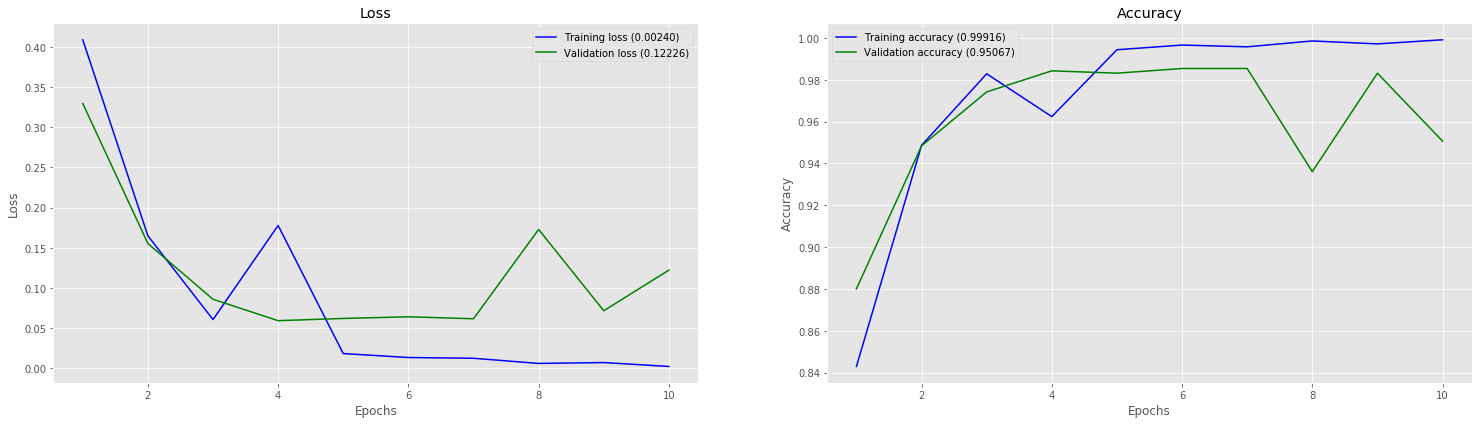

Confusion matrix, without normalization
[[937  29]
 [  7 142]]





==================================== SimpleRNN Summary ======================================== 
Dense layer size :  256
Embedding layer size :  20 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 50)                0         
_________________________________________________________________
embedding_37 (Embedding)     (None, 50, 20)            100000    
_________________________________________________________________
simple_rnn_37 (SimpleRNN)    (None, 64)                5440      
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_73 (Activation)   (None, 256)               0         
_______________________________________________________

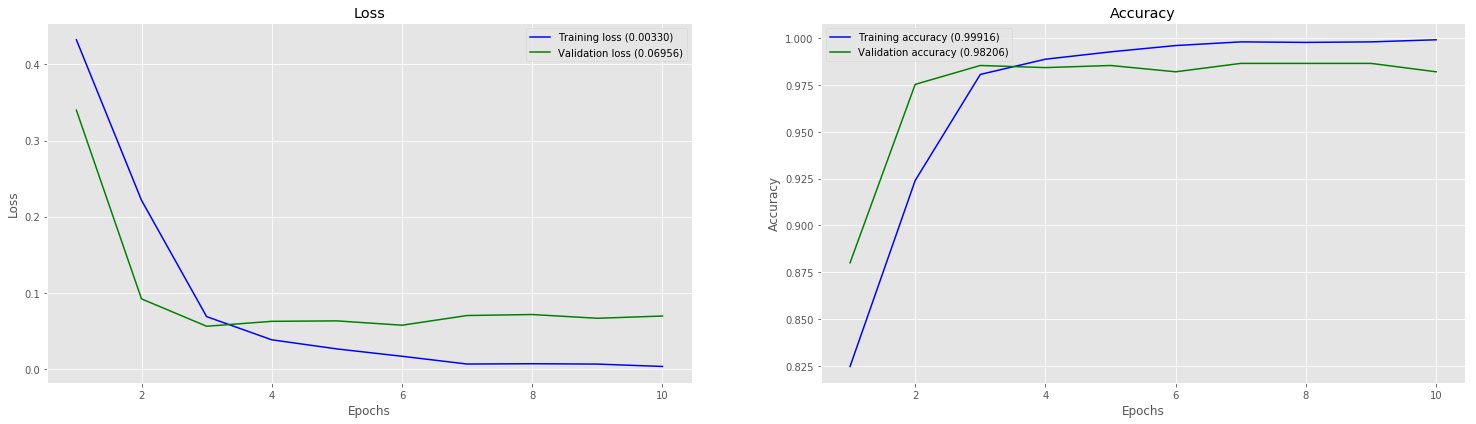

Confusion matrix, without normalization
[[964   2]
 [ 10 139]]





==================================== SimpleRNN Summary ======================================== 
Dense layer size :  300
Embedding layer size :  20 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 50)                0         
_________________________________________________________________
embedding_38 (Embedding)     (None, 50, 20)            100000    
_________________________________________________________________
simple_rnn_38 (SimpleRNN)    (None, 64)                5440      
_________________________________________________________________
FC1 (Dense)                  (None, 300)               19500     
_________________________________________________________________
activation_75 (Activation)   (None, 300)               0         
_______________________________________________________

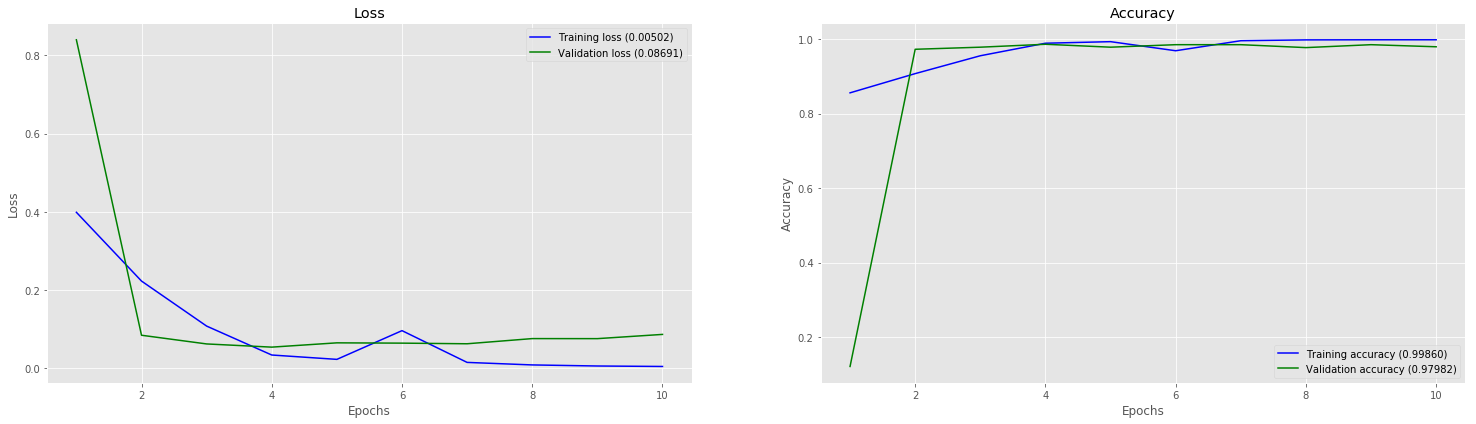

Confusion matrix, without normalization
[[965   1]
 [  9 140]]


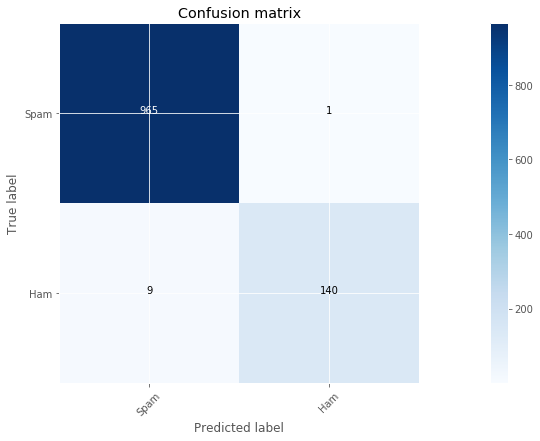

In [17]:
for embed_size in embeddings : 
    for size in denseLayerSizes :  
        inputs = Input(name='inputs',shape=[max_len])
        layer = Embedding(max_words,embed_size,input_length=max_len)(inputs)
        layer = SimpleRNN(64)(layer)
        layer = Dense(size,name='FC1')(layer)
        layer = Activation('relu')(layer)
        layer = Dropout(0.2)(layer)
        layer = Dense(1,name='out_layer')(layer)
        layer = Activation('sigmoid')(layer)
        model = Model(inputs=inputs,outputs=layer)
        print('\n\n\n\n\n==================================== SimpleRNN Summary ======================================== ')
        print('Dense layer size : ', size)
        print('Embedding layer size : ', embed_size,'\n\n')
        model.summary()
        model.compile(loss='binary_crossentropy', optimizer='rmsprop',metrics=['accuracy'])
        print('\n')
        plot_history(model.fit(sequences_matrix,y_train,batch_size=128,epochs=10,validation_split=0.2, callbacks=[metrics]))

        yhat = model.predict(sequences_matrix_test)
        
        cnf_matrix = confusion_matrix(y_test, yhat.round())
        np.set_printoptions(precision=2)

        # Plot non-normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=class_names)
        



==================================== LSTM Summary ======================================== 
Dense layer size :  200
Embedding layer size :  10 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 50)                0         
_________________________________________________________________
embedding_39 (Embedding)     (None, 50, 10)            50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                19200     
_________________________________________________________________
FC1 (Dense)                  (None, 200)               13000     
_________________________________________________________________
activation_77 (Activation)   (None, 200)               0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 200)               0    

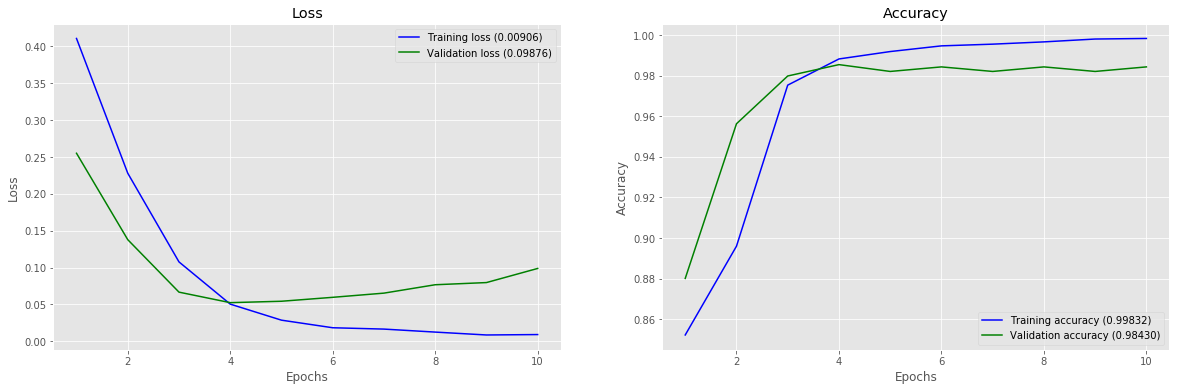

Confusion matrix, without normalization
[[966   0]
 [ 12 137]]


==================================== LSTM Summary ======================================== 
Dense layer size :  256
Embedding layer size :  10 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 50)                0         
_________________________________________________________________
embedding_40 (Embedding)     (None, 50, 10)            50000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                19200     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_79 (Activation)   (None, 256)               0         
_______________________________________________________________

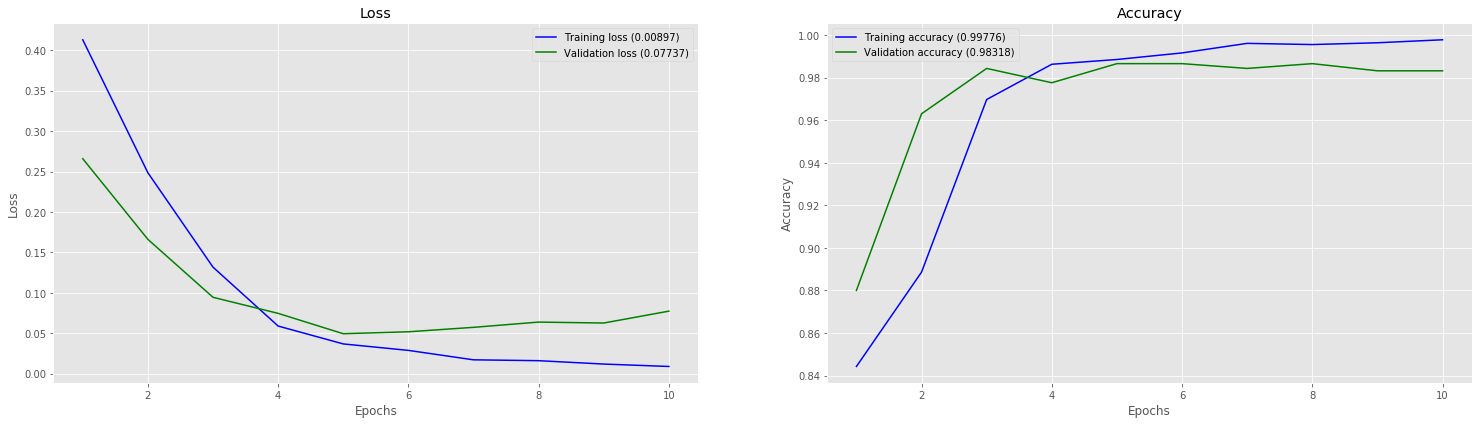

Confusion matrix, without normalization
[[965   1]
 [  8 141]]


==================================== LSTM Summary ======================================== 
Dense layer size :  300
Embedding layer size :  10 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 50)                0         
_________________________________________________________________
embedding_41 (Embedding)     (None, 50, 10)            50000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                19200     
_________________________________________________________________
FC1 (Dense)                  (None, 300)               19500     
_________________________________________________________________
activation_81 (Activation)   (None, 300)               0         
_______________________________________________________________

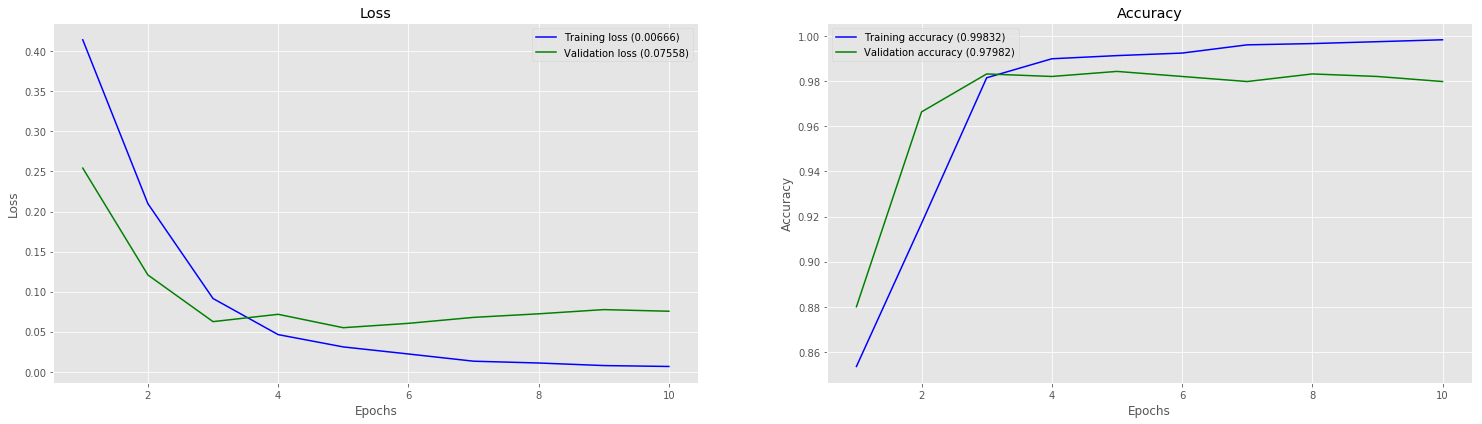

Confusion matrix, without normalization
[[964   2]
 [  7 142]]


==================================== LSTM Summary ======================================== 
Dense layer size :  200
Embedding layer size :  15 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 50)                0         
_________________________________________________________________
embedding_42 (Embedding)     (None, 50, 15)            75000     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                20480     
_________________________________________________________________
FC1 (Dense)                  (None, 200)               13000     
_________________________________________________________________
activation_83 (Activation)   (None, 200)               0         
_______________________________________________________________

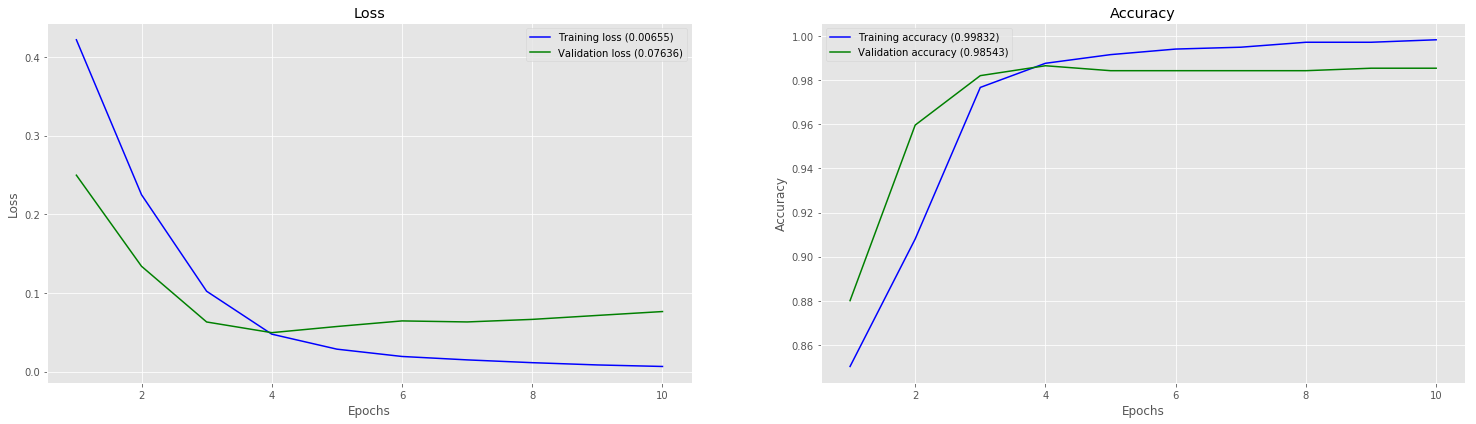

Confusion matrix, without normalization
[[966   0]
 [  8 141]]


==================================== LSTM Summary ======================================== 
Dense layer size :  256
Embedding layer size :  15 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 50)                0         
_________________________________________________________________
embedding_43 (Embedding)     (None, 50, 15)            75000     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                20480     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_85 (Activation)   (None, 256)               0         
_______________________________________________________________

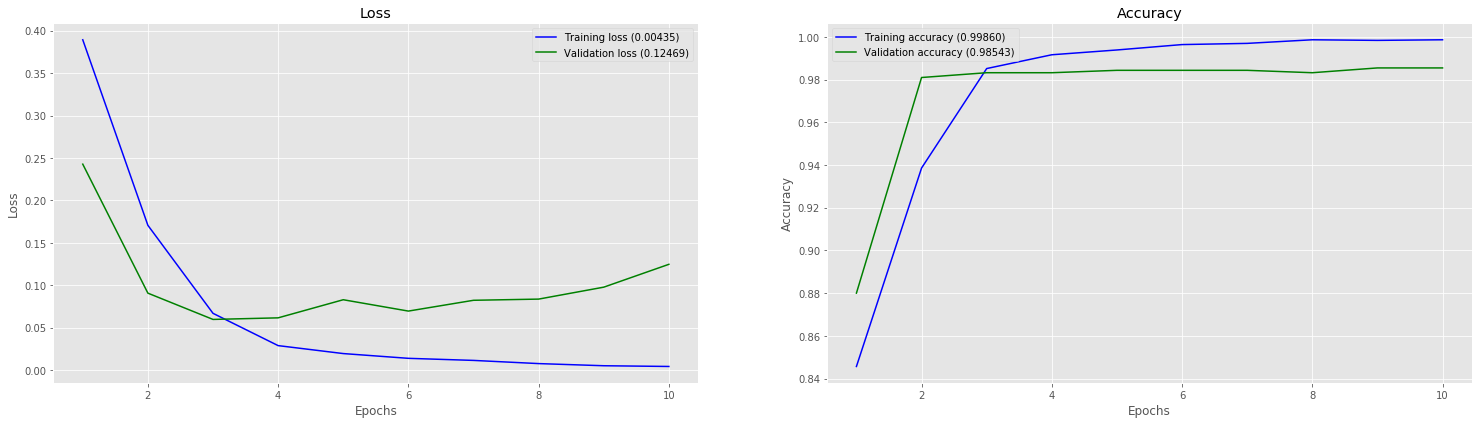

Confusion matrix, without normalization
[[966   0]
 [ 12 137]]


==================================== LSTM Summary ======================================== 
Dense layer size :  300
Embedding layer size :  15 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 50)                0         
_________________________________________________________________
embedding_44 (Embedding)     (None, 50, 15)            75000     
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                20480     
_________________________________________________________________
FC1 (Dense)                  (None, 300)               19500     
_________________________________________________________________
activation_87 (Activation)   (None, 300)               0         
_______________________________________________________________

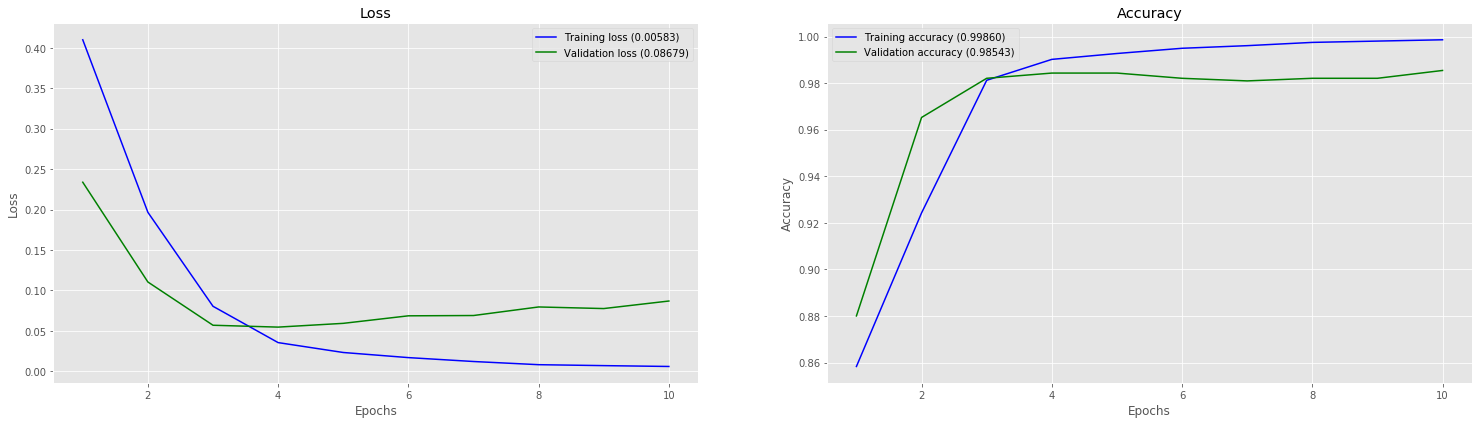

Confusion matrix, without normalization
[[965   1]
 [ 11 138]]


==================================== LSTM Summary ======================================== 
Dense layer size :  200
Embedding layer size :  20 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 50)                0         
_________________________________________________________________
embedding_45 (Embedding)     (None, 50, 20)            100000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                21760     
_________________________________________________________________
FC1 (Dense)                  (None, 200)               13000     
_________________________________________________________________
activation_89 (Activation)   (None, 200)               0         
_______________________________________________________________

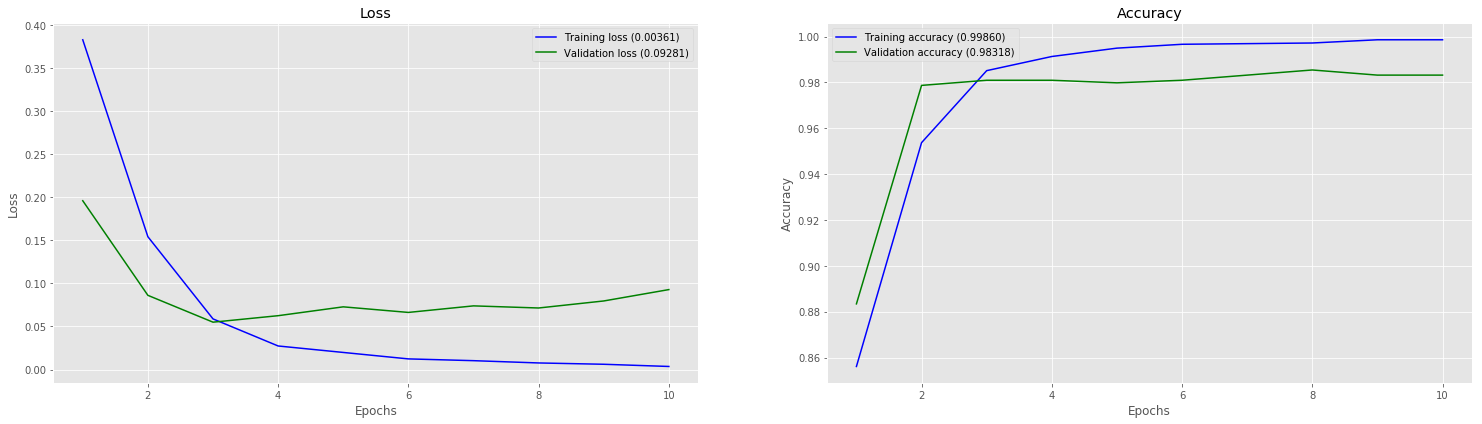

Confusion matrix, without normalization
[[964   2]
 [ 11 138]]


==================================== LSTM Summary ======================================== 
Dense layer size :  256
Embedding layer size :  20 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 50)                0         
_________________________________________________________________
embedding_46 (Embedding)     (None, 50, 20)            100000    
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                21760     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_91 (Activation)   (None, 256)               0         
_______________________________________________________________

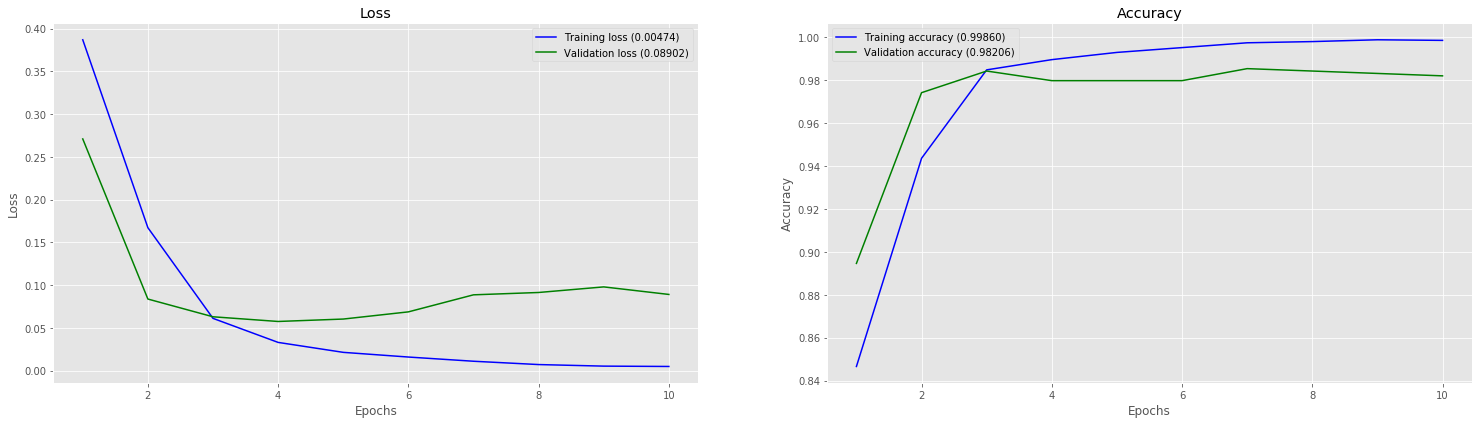

Confusion matrix, without normalization
[[962   4]
 [  8 141]]


==================================== LSTM Summary ======================================== 
Dense layer size :  300
Embedding layer size :  20 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 50)                0         
_________________________________________________________________
embedding_47 (Embedding)     (None, 50, 20)            100000    
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                21760     
_________________________________________________________________
FC1 (Dense)                  (None, 300)               19500     
_________________________________________________________________
activation_93 (Activation)   (None, 300)               0         
_______________________________________________________________

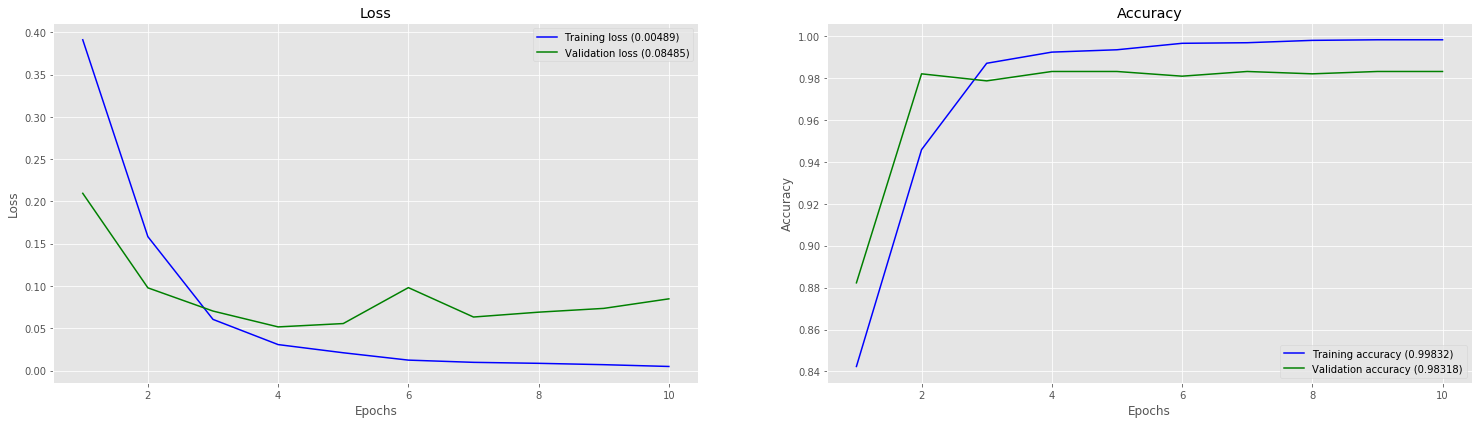

Confusion matrix, without normalization
[[962   4]
 [  8 141]]


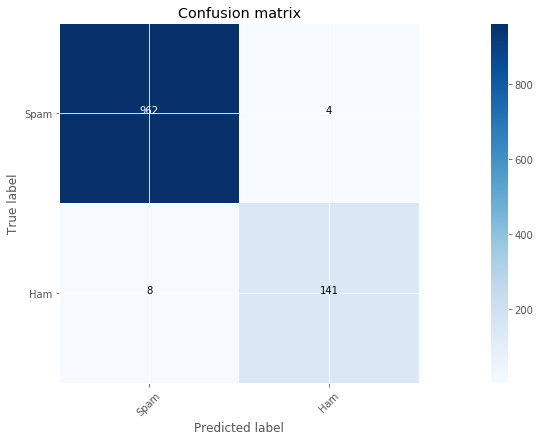

In [18]:
for embed_size in embeddings : 
    for size in denseLayerSizes :  
        inputs = Input(name='inputs',shape=[max_len])
        layer = Embedding(max_words,embed_size,input_length=max_len)(inputs)
        layer = LSTM(64)(layer)
        layer = Dense(size,name='FC1')(layer)
        layer = Activation('relu')(layer)
        layer = Dropout(0.2)(layer)
        layer = Dense(1,name='out_layer')(layer)
        layer = Activation('sigmoid')(layer)
        model = Model(inputs=inputs,outputs=layer)
        print('\n\n==================================== LSTM Summary ======================================== ')
        print('Dense layer size : ', size)
        print('Embedding layer size : ', embed_size,'\n\n')
        model.summary()
        model.compile(loss='binary_crossentropy', optimizer='rmsprop',metrics=['accuracy'])
        print('\n')
        plot_history(model.fit(sequences_matrix,y_train,batch_size=128,epochs=10,validation_split=0.2, callbacks=[metrics]))
        
        yhat = model.predict(sequences_matrix_test)
        
        cnf_matrix = confusion_matrix(y_test, yhat.round())
        np.set_printoptions(precision=2)

        # Plot non-normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=class_names)



==================================== GRU Summary ======================================== 
Dense layer size :  200
Embedding layer size :  10 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 50)                0         
_________________________________________________________________
embedding_48 (Embedding)     (None, 50, 10)            50000     
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                14400     
_________________________________________________________________
FC1 (Dense)                  (None, 200)               13000     
_________________________________________________________________
activation_95 (Activation)   (None, 200)               0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 200)               0     

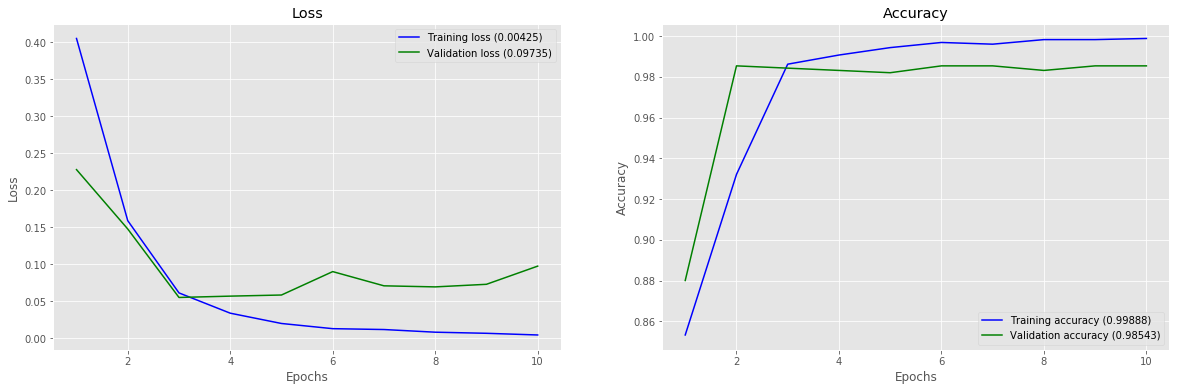

Confusion matrix, without normalization
[[965   1]
 [ 11 138]]


==================================== GRU Summary ======================================== 
Dense layer size :  256
Embedding layer size :  10 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 50)                0         
_________________________________________________________________
embedding_49 (Embedding)     (None, 50, 10)            50000     
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                14400     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_97 (Activation)   (None, 256)               0         
________________________________________________________________

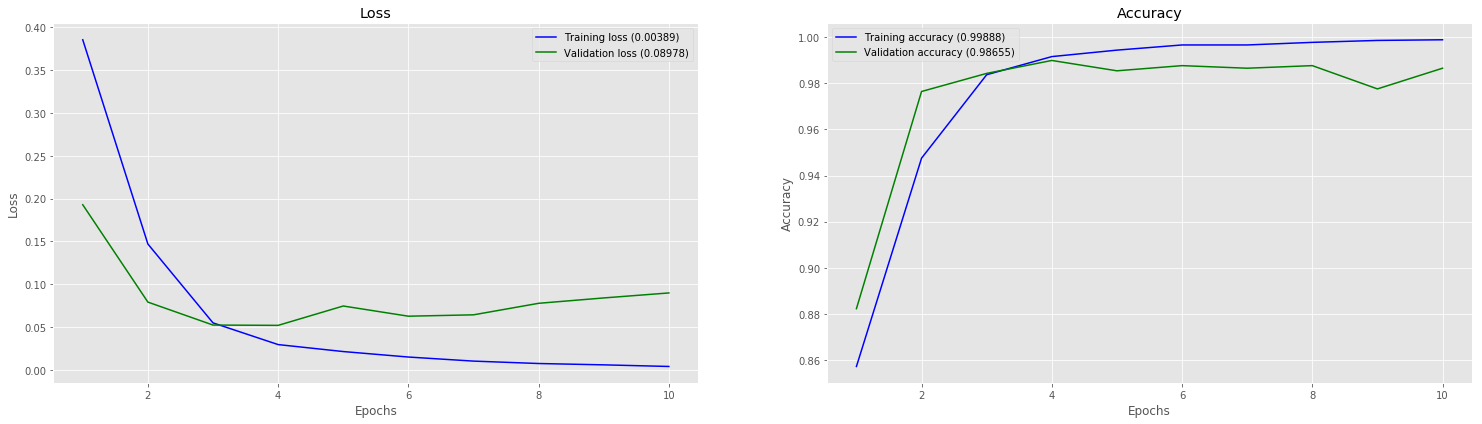

Confusion matrix, without normalization
[[964   2]
 [ 10 139]]


==================================== GRU Summary ======================================== 
Dense layer size :  300
Embedding layer size :  10 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 50)                0         
_________________________________________________________________
embedding_50 (Embedding)     (None, 50, 10)            50000     
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                14400     
_________________________________________________________________
FC1 (Dense)                  (None, 300)               19500     
_________________________________________________________________
activation_99 (Activation)   (None, 300)               0         
________________________________________________________________

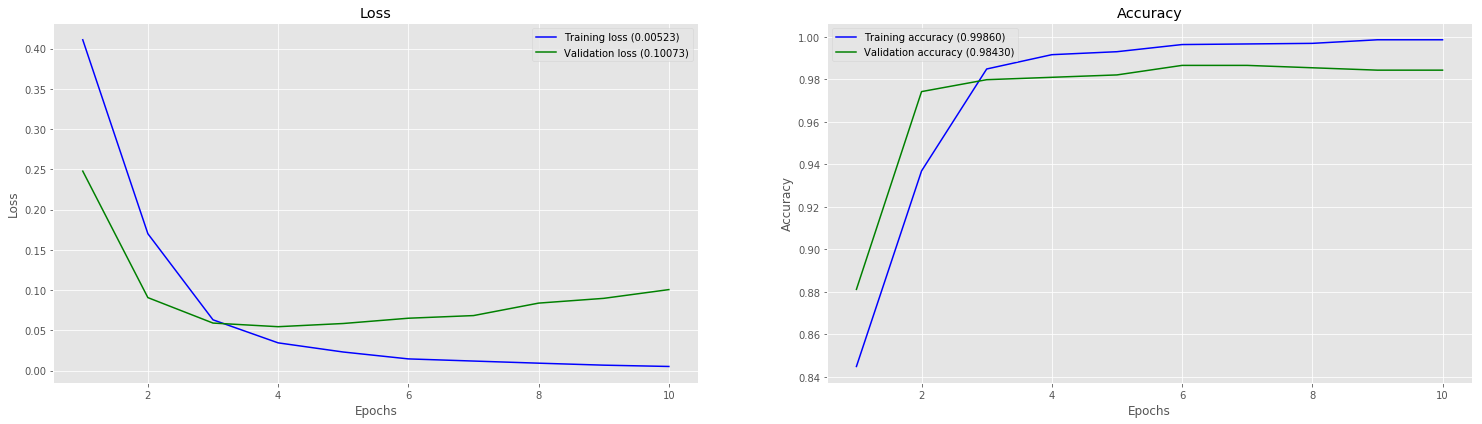

Confusion matrix, without normalization
[[966   0]
 [ 10 139]]


==================================== GRU Summary ======================================== 
Dense layer size :  200
Embedding layer size :  15 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 50)                0         
_________________________________________________________________
embedding_51 (Embedding)     (None, 50, 15)            75000     
_________________________________________________________________
gru_4 (GRU)                  (None, 64)                15360     
_________________________________________________________________
FC1 (Dense)                  (None, 200)               13000     
_________________________________________________________________
activation_101 (Activation)  (None, 200)               0         
________________________________________________________________

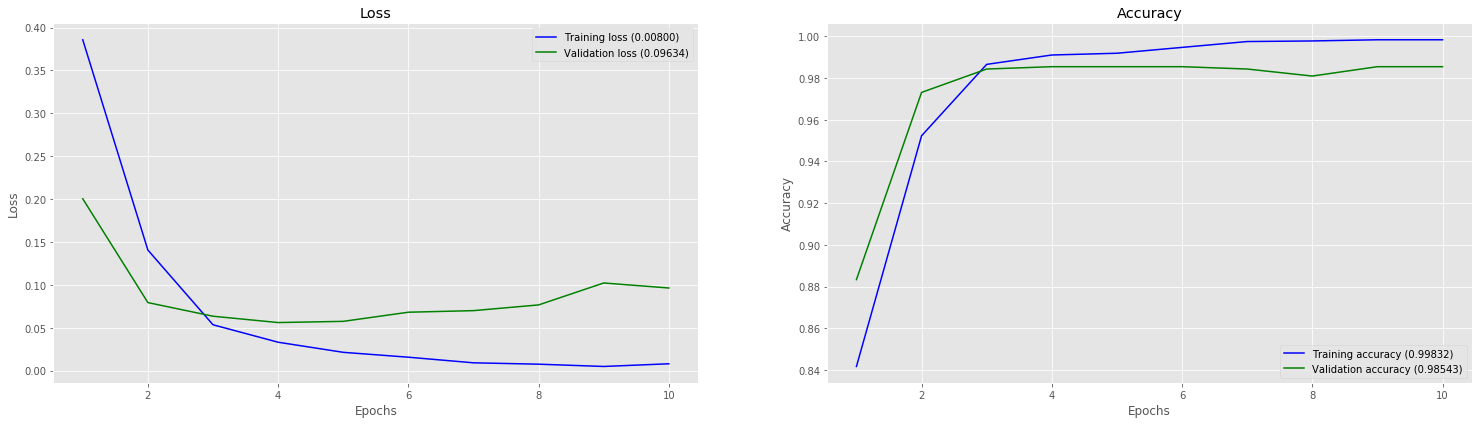

Confusion matrix, without normalization
[[964   2]
 [ 11 138]]


==================================== GRU Summary ======================================== 
Dense layer size :  256
Embedding layer size :  15 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 50)                0         
_________________________________________________________________
embedding_52 (Embedding)     (None, 50, 15)            75000     
_________________________________________________________________
gru_5 (GRU)                  (None, 64)                15360     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_103 (Activation)  (None, 256)               0         
________________________________________________________________

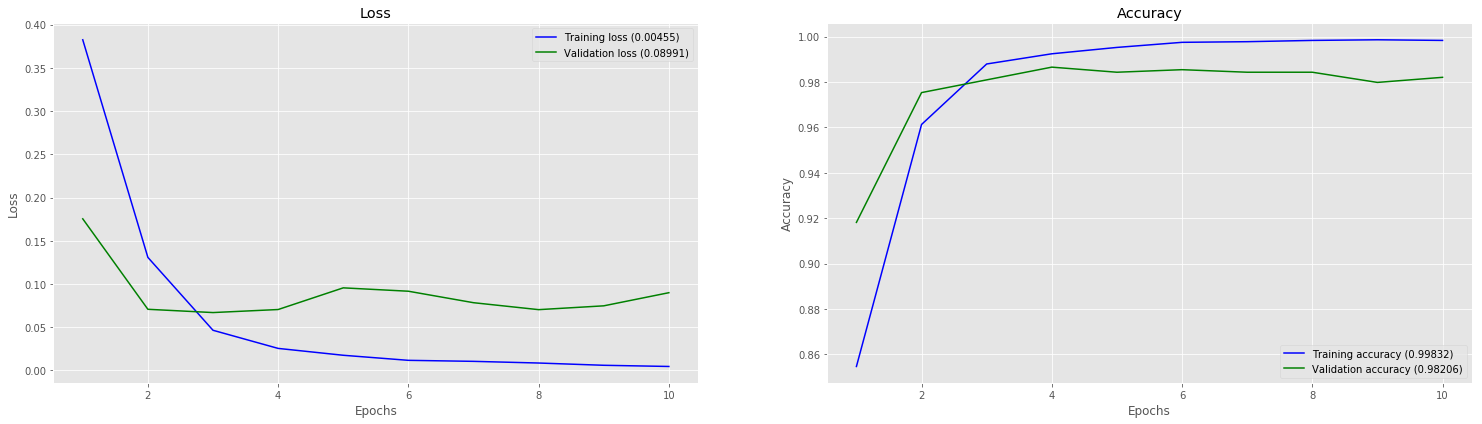

Confusion matrix, without normalization
[[961   5]
 [  9 140]]


==================================== GRU Summary ======================================== 
Dense layer size :  300
Embedding layer size :  15 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 50)                0         
_________________________________________________________________
embedding_53 (Embedding)     (None, 50, 15)            75000     
_________________________________________________________________
gru_6 (GRU)                  (None, 64)                15360     
_________________________________________________________________
FC1 (Dense)                  (None, 300)               19500     
_________________________________________________________________
activation_105 (Activation)  (None, 300)               0         
________________________________________________________________

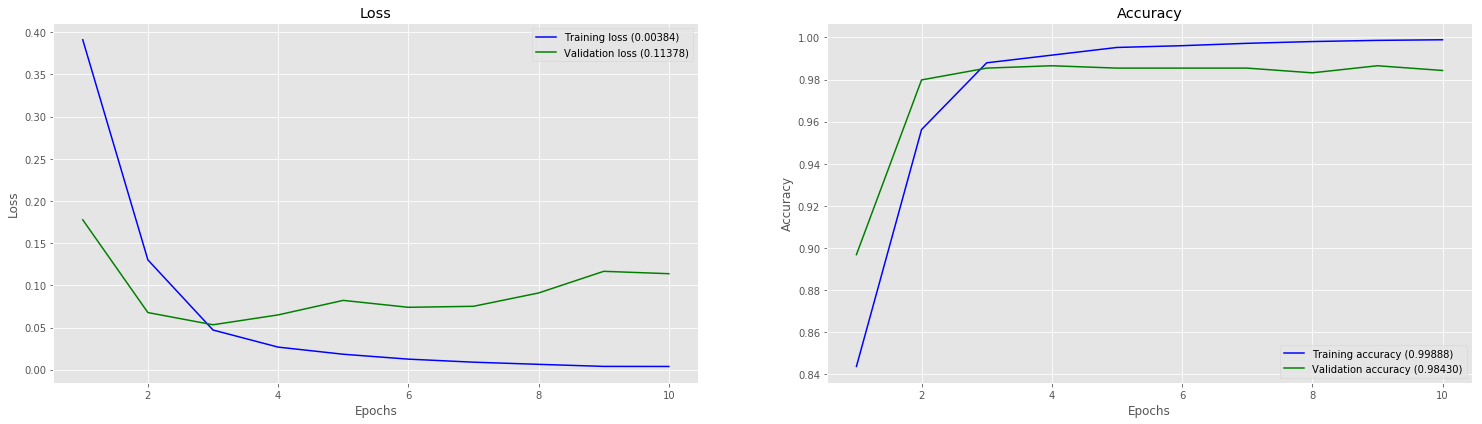

Confusion matrix, without normalization
[[963   3]
 [ 11 138]]


==================================== GRU Summary ======================================== 
Dense layer size :  200
Embedding layer size :  20 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 50)                0         
_________________________________________________________________
embedding_54 (Embedding)     (None, 50, 20)            100000    
_________________________________________________________________
gru_7 (GRU)                  (None, 64)                16320     
_________________________________________________________________
FC1 (Dense)                  (None, 200)               13000     
_________________________________________________________________
activation_107 (Activation)  (None, 200)               0         
________________________________________________________________

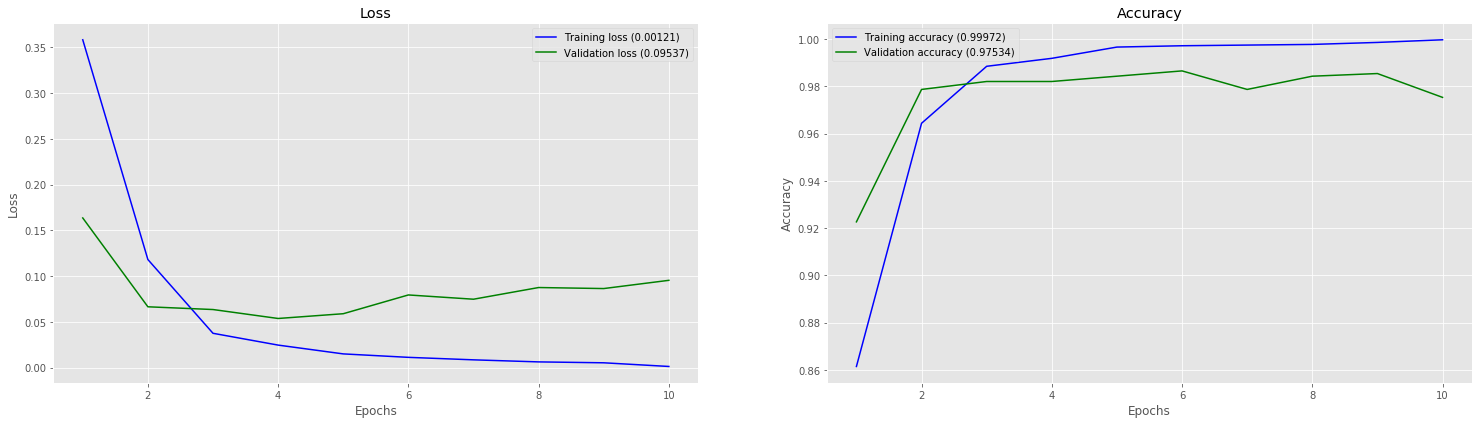

Confusion matrix, without normalization
[[959   7]
 [  9 140]]


==================================== GRU Summary ======================================== 
Dense layer size :  256
Embedding layer size :  20 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 50)                0         
_________________________________________________________________
embedding_55 (Embedding)     (None, 50, 20)            100000    
_________________________________________________________________
gru_8 (GRU)                  (None, 64)                16320     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_109 (Activation)  (None, 256)               0         
________________________________________________________________

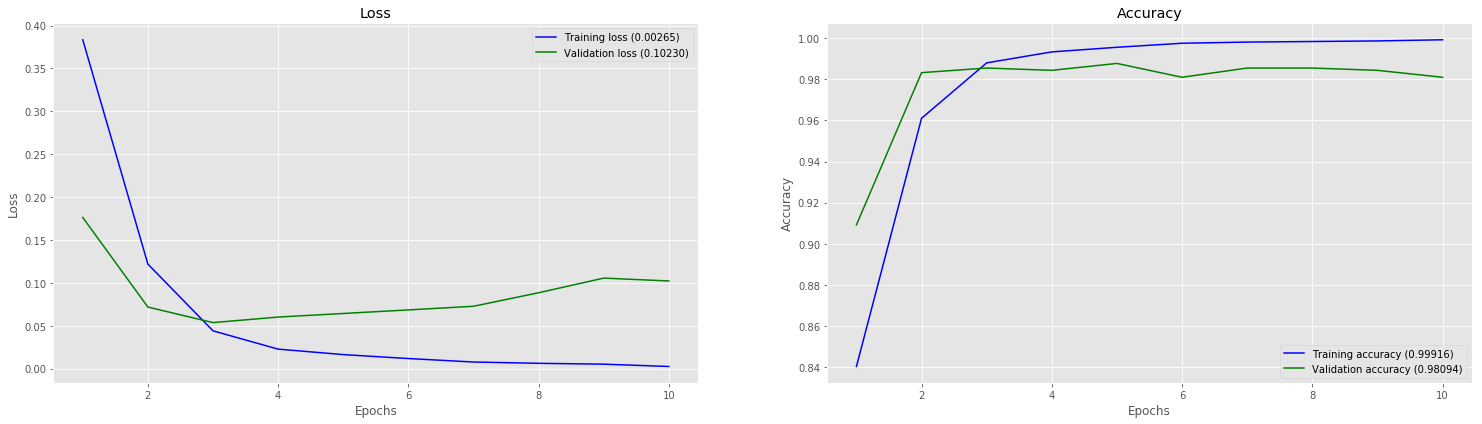

Confusion matrix, without normalization
[[960   6]
 [  9 140]]


==================================== GRU Summary ======================================== 
Dense layer size :  300
Embedding layer size :  20 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 50)                0         
_________________________________________________________________
embedding_56 (Embedding)     (None, 50, 20)            100000    
_________________________________________________________________
gru_9 (GRU)                  (None, 64)                16320     
_________________________________________________________________
FC1 (Dense)                  (None, 300)               19500     
_________________________________________________________________
activation_111 (Activation)  (None, 300)               0         
________________________________________________________________

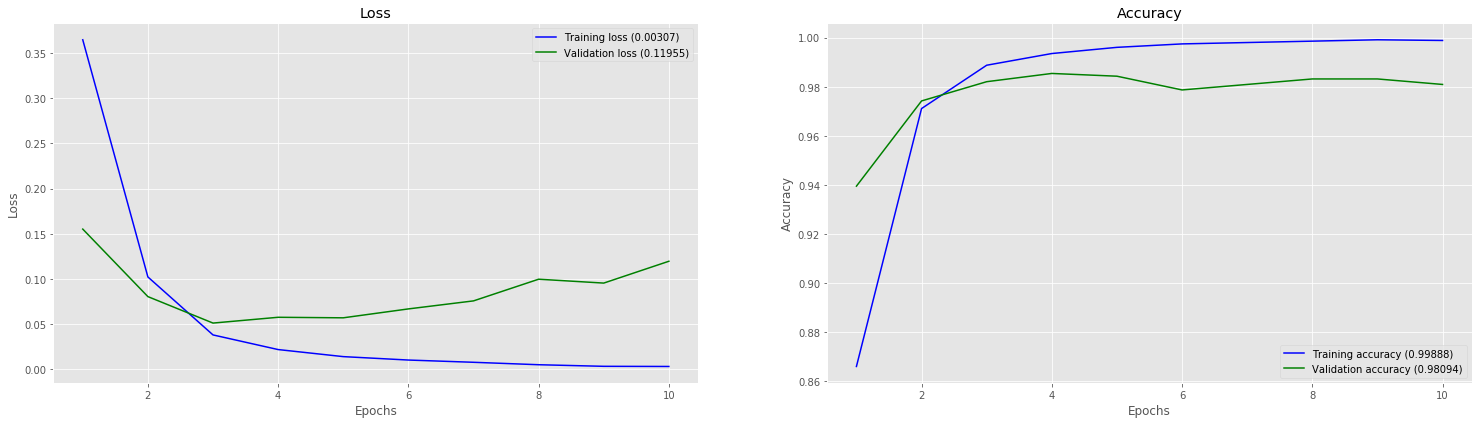

Confusion matrix, without normalization
[[964   2]
 [ 11 138]]


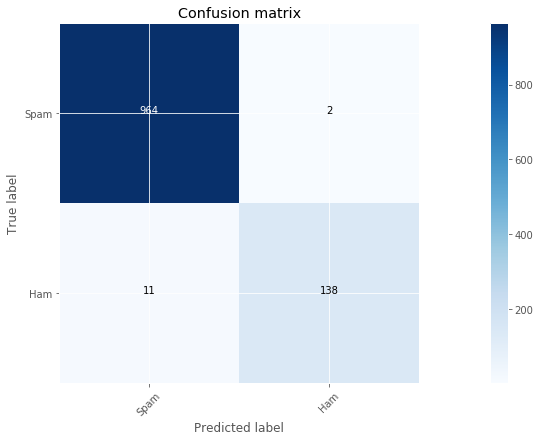

In [19]:
for embed_size in embeddings : 
    for size in denseLayerSizes :   
        inputs = Input(name='inputs',shape=[max_len])
        layer = Embedding(max_words,embed_size,input_length=max_len)(inputs)
        layer = GRU(64)(layer)
        layer = Dense(size,name='FC1')(layer)
        layer = Activation('relu')(layer)
        layer = Dropout(0.2)(layer)
        layer = Dense(1,name='out_layer')(layer)
        layer = Activation('sigmoid')(layer)
        model = Model(inputs=inputs,outputs=layer)
        print('\n\n==================================== GRU Summary ======================================== ')
        print('Dense layer size : ', size)
        print('Embedding layer size : ', embed_size,'\n\n')
        model.summary()
        model.compile(loss='binary_crossentropy', optimizer='rmsprop',metrics=['accuracy'])
        print('\n')
        plot_history(model.fit(sequences_matrix,y_train,batch_size=128,epochs=10,validation_split=0.2, callbacks=[metrics]))
        
        yhat = model.predict(sequences_matrix_test)
        
        cnf_matrix = confusion_matrix(y_test, yhat.round())
        np.set_printoptions(precision=2)

        # Plot non-normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=class_names)

## Model Comparisons:

<table class='table table-striped'> <thead> 
<tr> 
<th><u></u></th> 
<th><u>SimpleRNN</u></th> 
<th><u>LSTM</u></th> 
<th><u>GRU</u></th> 
</tr> 
</thead> 
<tbody> 
<tr > <th scope='row'>Best</th> 
    <td>Acc - 99.87<br>Precision - 98.43<br>FP - 0<br>Dense Layers - 300<br>Embed size - 15</td>
    <td>Acc - 99.86<br>Precision - 98.54<br>FP - 0<br>Dense Layers - 256<br>Embed size - 15</td>
    <td>Acc - 99.86<br>Precision - 98.43<br>FP - 0<br>Dense Layers - 300<br>Embed size - 10</td>
</tr>
<tr> <th scope='row'>Worst</th> 
    <td>Acc - 99.87<br>Precision - 98.09<br>FP - 27<br>Dense Layers - 200<br>Embed size - 20</td>
    <td>Acc - 99.86<br>Precision - 98.20<br>FP - 4<br>Dense Layers - 256<br>Embed size - 20</td>
    <td>Acc - 99.92<br>Precision - 97.53<br>FP - 7<br>Dense Layers - 200<br>Embed size - 20</td>
</tr>    
</tbody> 
</table>

From above table, it is apparent that as we increase embedding size, the number of false positives in the prediction also increases. Thus the best architecture is LSTM model with 256 dense layers and embedding size of 15.

## Impact of shorthand writing in text messages

In text messages, we often write messages in shorthand. So many words from the messages will not be present in the dictionary. Since we are focusing on only the spam messages, this shorthand writing will actually be a boon for us.

Most of the spam messages are about stuff like offers and promotions. These companies will never use shorthand writing in these messages. Thus all the words present in the spam messages will be present in the dictionary. Thus these messages have a high probablity of getting picked up in the bag of words.

Thus our model is going to train on words which are most occuring in spam messages. If we think about it, this  also helps us to negate the bias of uneven distribution of classes.

## 2.2 Two Recurrent Chain Model 

In [42]:
inputs = Input(name='inputs',shape=[max_len])

layer = Embedding(max_words,15,input_length=max_len)(inputs)
layer = LSTM(64)(layer)
layer = Dense(256,name='FC1')(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(1,name='out_layer1')(layer)
layer = Activation('sigmoid')(layer)
model = Model(inputs=inputs,outputs=layer)

lay2 = Embedding(max_words,15,input_length=max_len)(layer) # Here we pass output of chain 1 as input to chain 2
lay2 = LSTM(64)(lay2)
lay2 = Dense(1,name='out_layer2')(layer)
m = Model(inputs=inputs, outputs=lay2)


m.summary()
m.compile(loss='binary_crossentropy', optimizer='rmsprop',metrics=['accuracy'])


history = m.fit(sequences_matrix,y_train,batch_size=128,epochs=10,validation_split=0.2, callbacks=[metrics])

# print(inputs.get_shape)
# print(layer.get_shape)
yhat = m.predict(sequences_matrix_test)

print('Test Accuracy: ', accuracy_score(yhat.round(), y_test))
print('Test Precision: ', precision_score(yhat.round(), y_test))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 50)                0         
_________________________________________________________________
embedding_99 (Embedding)     (None, 50, 15)            75000     
_________________________________________________________________
lstm_52 (LSTM)               (None, 64)                20480     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_163 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_83 (Dropout)         (None, 256)               0         
_________________________________________________________________
out_layer1 (Dense)           (None, 1)                 257       
__________

When we add a second chain of layers to our best model, we get improvement in accuracy and precision on both, validation and test sets.

# 3.0 EXCEPTIONAL WORK

For this section we are using the pre-trained data from glove.
Reference : https://github.com/eclarson/MachineLearningNotebooks/blob/master/13.%20RNN%20Basics.ipynb
The code for populating the embedding_index dictionary from the glove.6B.100.txt was taken as it is from the above reference given

We have used the embedding size of 100 because the glove embedded layer we are using is of embedded size 100.

In [44]:
%%time
import numpy as np

EMBED_SIZE = 100
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('/Users/piyushmetkar/Documents/SMU/Notes/Spring 18/7324 Machine Learning in Python/Lab 7/glove.6B/glove.6B.100d.txt', encoding="utf8")
# f = open(r'D:\Downloads\Notes\CSE_7324_ML\sms-spam-collection-dataset\glove.6B.100d.txt', encoding="utf8")
#f = open('/Users/dhavalgogri/Downloads/glove/glove.6B.100d.txt', encoding="utf8")
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.
Wall time: 7.11 s


We populated a total of 400000 word vectors in the dictionary.

From the 400000 words we are randomly selecting 300 words so as to not clutter the graph and clearly identify the plotted vectors in the graph.

Reference : https://www.kaggle.com/futurist/visualising-data-using-t-sne-with-hypertools/code

We used fit_transform from the above reference for vectors and tsne.
We also refered the video from the above link to understand the working.

Later we use tsne to reduce the dimensionality of the embedded words. Here the words are mapped in a scatter plot as a point and the distance between the words reflect the similarities between the words. This distance is referred as Euclidian distance. 

In [45]:
import random
from sklearn.feature_extraction.text import TfidfVectorizer
randomWords = {}
for i in range(300) : 
        key = random.choice(list(embeddings_index.keys()))
        randomWords[key] = embeddings_index[key]

vectors = TfidfVectorizer().fit_transform(randomWords)

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
X_reduced = TruncatedSVD(n_components=100, random_state=0).fit_transform(vectors)
tsne = TSNE(n_components=2, perplexity=110, verbose=2).fit_transform(X_reduced)



[t-SNE] Computing 299 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.000s...
[t-SNE] Computed neighbors for 300 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 0.281447
[t-SNE] Computed conditional probabilities in 0.035s
[t-SNE] Iteration 50: error = 80.1362152, gradient norm = 0.3797359 (50 iterations in 0.583s)
[t-SNE] Iteration 100: error = 76.9376068, gradient norm = 0.3747592 (50 iterations in 0.595s)
[t-SNE] Iteration 150: error = 80.0958252, gradient norm = 0.3428944 (50 iterations in 0.619s)
[t-SNE] Iteration 200: error = 88.5894394, gradient norm = 0.3305075 (50 iterations in 0.548s)
[t-SNE] Iteration 250: error = 90.2823868, gradient norm = 0.3376360 (50 iterations in 0.548s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.282387
[t-SNE] Iteration 300: error = 3.2866468, gradient norm = 0.0019369 (50 iterations in 0.506s)
[t-SNE] Iteration 350: error = 2.0896800, gradient norm = 0.0107436 

From the 300 words which are randomly selected, the words are stored as labels and their embedded values are stored as tokens. We fetch the X and Y cordinates from the tsne model and create a scatter plot. 

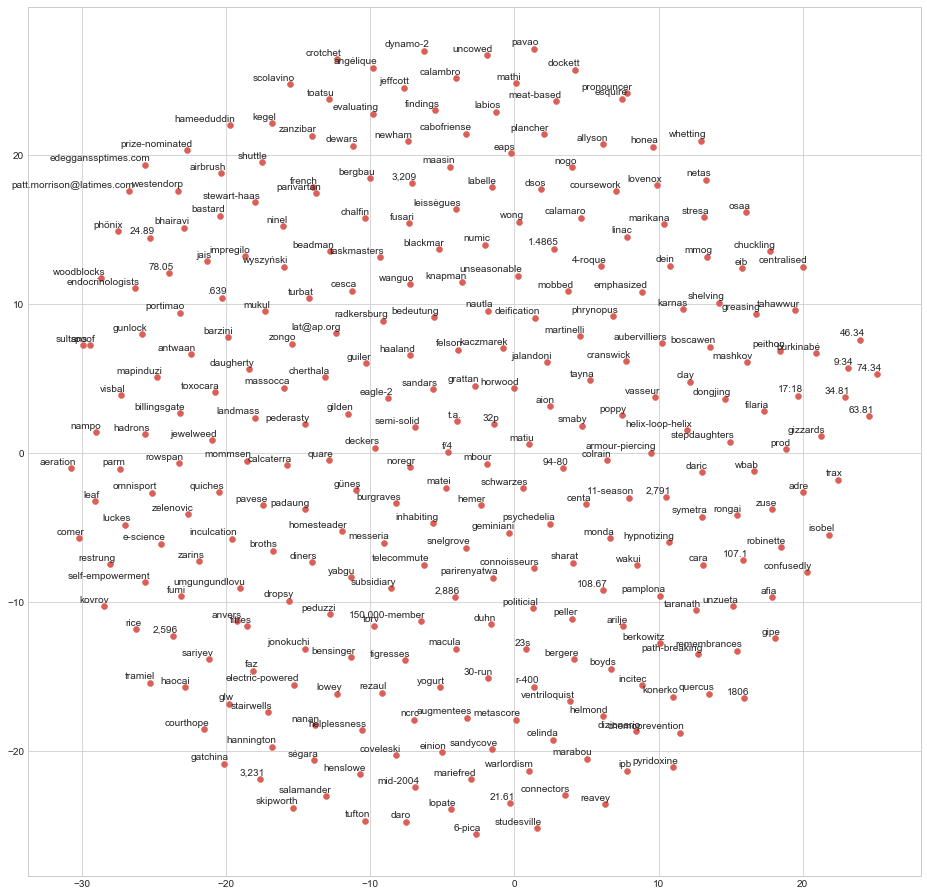

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

tokens = []
labels = []

tokens= (list(randomWords.values()))
labels= (list(randomWords.keys()))

    
new_values = tsne_model.fit_transform(tsne)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
        
plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                    xy=(x[i], y[i]),
                    xytext=(5, 2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')
plt.show()

The above scatter plot shows the position of the 300 words and their relation with each other.


Now we manually pair up some of the words which are analogous to each other like man-woman, king-queen. We only plot these words again in the map.

[t-SNE] Computing 9 nearest neighbors...
[t-SNE] Indexed 10 samples in 0.001s...
[t-SNE] Computed neighbors for 10 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 10 / 10
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Computed conditional probabilities in 0.000s
[t-SNE] Iteration 50: error = 68.9747009, gradient norm = 0.6118293 (50 iterations in 0.007s)
[t-SNE] Iteration 100: error = 40.7419281, gradient norm = 0.2772569 (50 iterations in 0.009s)
[t-SNE] Iteration 150: error = 53.8703308, gradient norm = 0.2057986 (50 iterations in 0.009s)
[t-SNE] Iteration 200: error = 39.1637154, gradient norm = 0.3212080 (50 iterations in 0.007s)
[t-SNE] Iteration 250: error = 50.9682808, gradient norm = 0.5425526 (50 iterations in 0.007s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.968281
[t-SNE] Iteration 300: error = 0.2630347, gradient norm = 0.0006552 (50 iterations in 0.006s)
[t-SNE] Iteration 350: error = 0.2510710, gradient norm = 0

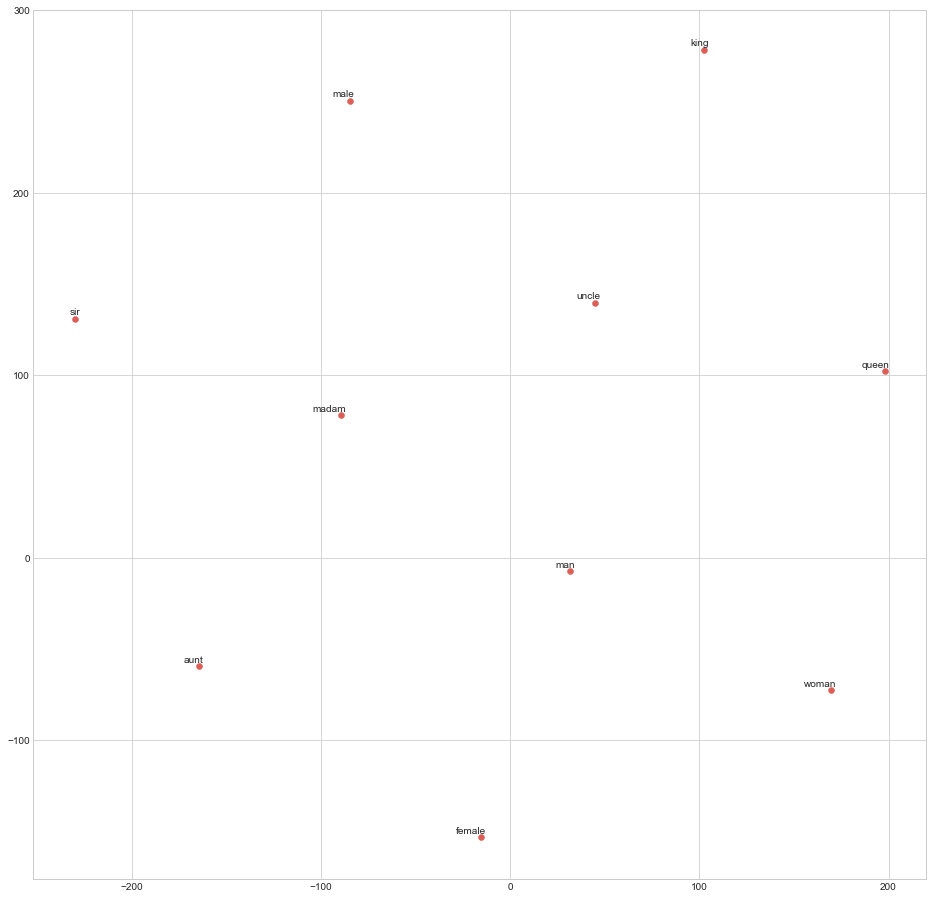

In [49]:

randomWordsNew={}
randomWordsNew['man'] = embeddings_index['man']
randomWordsNew['woman'] = embeddings_index['woman']

randomWordsNew['king'] = embeddings_index['king']
randomWordsNew['queen'] = embeddings_index['queen']

randomWordsNew['sir'] = embeddings_index['sir']
randomWordsNew['madam'] = embeddings_index['madam']

randomWordsNew['uncle'] = embeddings_index['uncle']
randomWordsNew['aunt'] = embeddings_index['aunt']

randomWordsNew['male'] = embeddings_index['male']
randomWordsNew['female'] = embeddings_index['female']

vectors = TfidfVectorizer().fit_transform(randomWordsNew)

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
X_reduced = TruncatedSVD(n_components=3, random_state=0).fit_transform(vectors)
tsne = TSNE(n_components=2, perplexity=110, verbose=2).fit_transform(X_reduced)

import matplotlib.pyplot as plt
%matplotlib inline

tokens = []
labels = []

tokens= (list(randomWordsNew.values()))
labels= (list(randomWordsNew.keys()))

    
#tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tsne)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
        
plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                    xy=(x[i], y[i]),
                    xytext=(5, 2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')
#     if(i%2==0) :
#         plt.plot([x[i],y[i],x[(i+1)],y[(i+1)]])
plt.show()

From the above scatter plot we see that the alignment i.e. the relative position of one point with respect to other for few pairs like king-queen, sir-madam, man-woman is similar which is as expected since those pairs are analogous to each other. This also gives an indication that the dimensionality reduction of the glove embedding was proper.